In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import ast
from PIL import Image
from datetime import datetime

In [2]:
cgm_test = pd.read_csv('633FinalData/cgm_test.csv')
cgm_train = pd.read_csv('633FinalData/cgm_train.csv')
img_train = pd.read_csv('633FinalData/img_train.csv')
img_test = pd.read_csv('633FinalData/img_test.csv')
cgm_test['cgm'] = cgm_test['CGM Data'].apply(lambda x: ast.literal_eval(x))
cgm_train['cgm'] = cgm_train['CGM Data'].apply(lambda x: ast.literal_eval(x))
def get_img(img):
    # Convert the string representation of the image to a list
    img = ast.literal_eval(img)
    
    # Convert the list to a NumPy array
    img = np.array(img)
    
    # Convert the NumPy array to a PIL Image
    img = Image.fromarray(np.uint8(img))
    
    # Resize the image
    img = img.resize((64,64))
    
    # Convert the resized image back to a NumPy array
    img = np.array(img)
    
    if len(img.shape) == 2:
        img = np.stack((img,)*3, axis=-1)
    return img

img_train['img_b'] = img_train['Image Before Breakfast'].apply(get_img)
img_train['img_l'] = img_train['Image Before Lunch'].apply(get_img)
img_test['img_b'] = img_test['Image Before Breakfast'].apply(get_img)
img_test['img_l'] = img_test['Image Before Lunch'].apply(get_img)

def to_step(t):
    date_obj = datetime.strptime(t, '%Y-%m-%d %H:%M:%S')
    return (date_obj.hour*60 + date_obj.minute)//5

def cgm_to_steps(cgm):
    steps = [0 for _ in range(288)]
    for t,value in cgm:
        steps[to_step(t)] = value
    return steps

def time_to_step(t1,t2):
    if t1 == '{}' or t2 == '{}':
        return [0 for _ in range(288)]
    steps = [0 for _ in range(288)]
    steps[to_step(t1)] = 1
    steps[to_step(t2)] = 1
    return steps

cgm_train = cgm_train.dropna()

cgm_train = cgm_train[~cgm_train.apply(lambda row: row.astype(str).str.contains('{}').any(), axis=1)]

cgm_test['cgm_sequential'] = cgm_test['cgm'].apply(cgm_to_steps)
cgm_train['cgm_sequential'] = cgm_train['cgm'].apply(cgm_to_steps)
cgm_train['when_to_eat'] = cgm_train[['Breakfast Time', 'Lunch Time']].apply(lambda x: time_to_step(x['Breakfast Time'], x['Lunch Time']), axis=1)
cgm_test['when_to_eat'] = cgm_test[['Breakfast Time', 'Lunch Time']].apply(lambda x: time_to_step(x['Breakfast Time'], x['Lunch Time']), axis=1)
viome_test = pd.read_csv('633FinalData/demo_viome_test.csv')
viome_train = pd.read_csv('633FinalData/demo_viome_train.csv')
viome_test= pd.get_dummies(viome_test, columns=['Race'])
viome_train= pd.get_dummies(viome_train, columns=['Race'])
viome_test['viome_sequential'] = viome_test['Viome'].apply(lambda x :[float(x) for x in x.split(',')])
viome_train['viome_sequential'] = viome_train['Viome'].apply(lambda x :[float(x) for x in x.split(',')])
combined_train = pd.merge(cgm_train, img_train, on=['Subject ID', 'Day'])
combined_train = pd.merge(combined_train, viome_train, on=['Subject ID'])
combined_test = pd.merge(cgm_test, img_test, on=['Subject ID', 'Day'])
combined_test = pd.merge(combined_test, viome_test, on=['Subject ID'])
to_drop_train = ['Subject ID','Day','Breakfast Time','Lunch Time','CGM Data','Image Before Breakfast','Image Before Lunch','Viome']
combined_train = combined_train.drop(to_drop_train, axis=1)
to_drop_test = ['Subject ID','Day','Breakfast Time','Lunch Time','CGM Data','Image Before Breakfast','Image Before Lunch','Viome']
to_drop_test = ['Subject ID','Day','Breakfast Time','Lunch Time','CGM Data','Image Before Breakfast','Image Before Lunch','Viome']
combined_test = combined_test.drop(to_drop_train, axis=1)
label_train = pd.read_csv('633FinalData/label_train.csv')
label_train = label_train['Lunch Calories']
combined_train['label'] = label_train

In [3]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Small epsilon value to avoid division by zero
        epsilon = 1e-6

        # Extract sequential data
        cgm_sequential = np.array(row['cgm_sequential'], dtype=float)
        when_to_eat = np.array(row['when_to_eat'], dtype=float)

        # Normalize sequential data
        cgm_sequential = (cgm_sequential - np.mean(cgm_sequential)) / (np.std(cgm_sequential) + epsilon)
        when_to_eat = (when_to_eat - np.mean(when_to_eat)) / (np.std(when_to_eat) + epsilon)

        # Stack cgm_sequential and when_to_eat to create a sequential data array with 2 features
        sequential_data = np.stack((cgm_sequential, when_to_eat), axis=-1)

        # Extract image data
        img_b = np.array(row['img_b'], dtype=float)
        img_l = np.array(row['img_l'], dtype=float)

        # Normalize image data
        img_b = (img_b - np.mean(img_b)) / (np.std(img_b) + epsilon)
        img_l = (img_l - np.mean(img_l)) / (np.std(img_l) + epsilon)

        # Ensure img_b has 3 channels
        if img_b.ndim == 2:  # Grayscale image
            img_b = np.stack((img_b, img_b, img_b), axis=-1)

        # Ensure img_l has 3 channels
        if img_l.ndim == 2:  # Grayscale image
            img_l = np.stack((img_l, img_l, img_l), axis=-1)

        # Convert image data to PIL Image and then to tensor
        img_b = Image.fromarray(np.uint8(img_b))
        img_l = Image.fromarray(np.uint8(img_l))
        img_b = torch.tensor(np.array(img_b), dtype=torch.float32).permute(2, 0, 1)  # Convert to CxHxW
        img_l = torch.tensor(np.array(img_l), dtype=torch.float32).permute(2, 0, 1)  # Convert to CxHxW

        # Extract numeric data
        numeric_data = row[['Age', 'Gender', 'Weight', 'Height', 'Diabetes Status', 'A1C',
                            'Baseline Fasting Glucose', 'Insulin', 'Triglycerides', 'Cholesterol',
                            'HDL', 'Non-HDL', 'LDL', 'VLDL', 'CHO/HDL Ratio', 'HOMA-IR', 'BMI',
                            'Race_African American', 'Race_Hispanic/Latino', 'Race_White']].values.astype(np.float32)

        # Normalize numeric data
        numeric_data = (numeric_data - np.mean(numeric_data)) / (np.std(numeric_data) + epsilon)
        numeric_data = torch.tensor(numeric_data, dtype=torch.float32)

        # Extract and reshape viome_sequential
        viome_sequential = np.array(row['viome_sequential'], dtype=float).reshape(27, 1)

        # Normalize viome_sequential
        viome_sequential = (viome_sequential - np.mean(viome_sequential)) / (np.std(viome_sequential) + epsilon)

        label_train = row['label']

        return {
            'sequential_data': torch.tensor(sequential_data, dtype=torch.float32),
            'viome_sequential': torch.tensor(viome_sequential, dtype=torch.float32),
            'img_b': img_b,
            'img_l': img_l,
            'numeric_data': numeric_data,
            'label': label_train
        }
        
class CustomTestDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Small epsilon value to avoid division by zero
        epsilon = 1e-6

        # Extract sequential data
        cgm_sequential = np.array(row['cgm_sequential'], dtype=float)
        when_to_eat = np.array(row['when_to_eat'], dtype=float)

        # Normalize sequential data
        cgm_sequential = (cgm_sequential - np.mean(cgm_sequential)) / (np.std(cgm_sequential) + epsilon)
        when_to_eat = (when_to_eat - np.mean(when_to_eat)) / (np.std(when_to_eat) + epsilon)

        # Stack cgm_sequential and when_to_eat to create a sequential data array with 2 features
        sequential_data = np.stack((cgm_sequential, when_to_eat), axis=-1)

        # Extract image data
        img_b = np.array(row['img_b'], dtype=float)
        img_l = np.array(row['img_l'], dtype=float)

        # Normalize image data
        img_b = (img_b - np.mean(img_b)) / (np.std(img_b) + epsilon)
        img_l = (img_l - np.mean(img_l)) / (np.std(img_l) + epsilon)

        # Ensure img_b has 3 channels
        if img_b.ndim == 2:  # Grayscale image
            img_b = np.stack((img_b, img_b, img_b), axis=-1)

        # Ensure img_l has 3 channels
        if img_l.ndim == 2:  # Grayscale image
            img_l = np.stack((img_l, img_l, img_l), axis=-1)

        # Convert image data to PIL Image and then to tensor
        img_b = Image.fromarray(np.uint8(img_b))
        img_l = Image.fromarray(np.uint8(img_l))
        img_b = torch.tensor(np.array(img_b), dtype=torch.float32).permute(2, 0, 1)  # Convert to CxHxW
        img_l = torch.tensor(np.array(img_l), dtype=torch.float32).permute(2, 0, 1)  # Convert to CxHxW

        # Extract numeric data
        numeric_data = row[['Age', 'Gender', 'Weight', 'Height', 'Diabetes Status', 'A1C',
                            'Baseline Fasting Glucose', 'Insulin', 'Triglycerides', 'Cholesterol',
                            'HDL', 'Non-HDL', 'LDL', 'VLDL', 'CHO/HDL Ratio', 'HOMA-IR', 'BMI',
                            'Race_African American', 'Race_Hispanic/Latino', 'Race_White']].values.astype(np.float32)

        # Normalize numeric data
        numeric_data = (numeric_data - np.mean(numeric_data)) / (np.std(numeric_data) + epsilon)
        numeric_data = torch.tensor(numeric_data, dtype=torch.float32)

        # Extract and reshape viome_sequential
        viome_sequential = np.array(row['viome_sequential'], dtype=float).reshape(27, 1)

        # Normalize viome_sequential
        viome_sequential = (viome_sequential - np.mean(viome_sequential)) / (np.std(viome_sequential) + epsilon)


        return {
            'sequential_data': torch.tensor(sequential_data, dtype=torch.float32),
            'viome_sequential': torch.tensor(viome_sequential, dtype=torch.float32),
            'img_b': img_b,
            'img_l': img_l,
            'numeric_data': numeric_data,
        }

In [4]:
dataset_train = CustomDataset(combined_train)
dataset_test = CustomTestDataset(combined_test)
combined_train['img_b'].apply(lambda x: x.shape).unique()

for i in range(1):
    sample = dataset_train[i]
    print(f"Sample {i}:")
    print(f"  sequential_data shape: {sample['sequential_data'].shape}")
    print(f"  viome_sequential shape: {sample['viome_sequential'].shape}")
    print(f"  img_b shape: {sample['img_b'].shape}")
    print(f"  img_l shape: {sample['img_l'].shape}")
    print(f"  numeric_data shape: {sample['numeric_data'].shape}")
    print(f"  label: {sample['label']}")

Sample 0:
  sequential_data shape: torch.Size([288, 2])
  viome_sequential shape: torch.Size([27, 1])
  img_b shape: torch.Size([3, 64, 64])
  img_l shape: torch.Size([3, 64, 64])
  numeric_data shape: torch.Size([20])
  label: 830


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models

class CombinedModel(nn.Module):
    def __init__(self, hidden_size=64):
        super(CombinedModel, self).__init__()
        
        # Sequential data sub-network
        self.seq_net = nn.LSTM(input_size=2, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.seq_fc = nn.Linear(hidden_size, 32)
        
        # Viome sequential data sub-network
        self.viome_net = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.viome_fc = nn.Linear(hidden_size, 32)
        
        # Image data sub-network using pre-trained ResNet
        self.img_net = models.resnet50(pretrained=False)
        self.img_net.fc = nn.Linear(self.img_net.fc.in_features, 32)  # Modify the final layer
        
        # Numeric data sub-network
        self.num_net = nn.Sequential(
            nn.Linear(20, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        
        # Combined fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(32 + 32 + 32 + 32 + 16, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Assuming a regression task
        )
    
    def forward(self, sequential_data, img_b, img_l, numeric_data, viome_sequential):
        # Process sequential data
        seq_out, _ = self.seq_net(sequential_data)
        seq_out = self.seq_fc(seq_out[:, -1, :])  # Take the last output of the LSTM and pass through a linear layer
        
        # Process viome sequential data
        viome_out, _ = self.viome_net(viome_sequential)
        viome_out = self.viome_fc(viome_out[:, -1, :])  # Take the last output of the LSTM and pass through a linear layer
        
        # Process image data
        img_b_out = self.img_net(img_b)
        img_l_out = self.img_net(img_l)
        
        # Process numeric data
        num_out = self.num_net(numeric_data)
        
        # Concatenate all outputs
        combined = torch.cat((seq_out, viome_out, img_b_out, img_l_out, num_out), dim=1)
        
        # Pass through fully connected layers
        out = self.fc(combined)
        
        return out

c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Loss: 0.9797210428449843
Epoch [2/50], Loss: 0.8379740118980408
Epoch [3/50], Loss: 0.5090599126285977
Epoch [4/50], Loss: 0.3614649242824978
Epoch [5/50], Loss: 0.33659889300664264
Epoch [6/50], Loss: 0.33484194344944423
Epoch [7/50], Loss: 0.33350226614210343
Epoch [8/50], Loss: 0.33361560106277466
Epoch [9/50], Loss: 0.33550000853008694
Epoch [10/50], Loss: 0.3327505952782101
Epoch [11/50], Loss: 0.3334180878268348
Epoch [12/50], Loss: 0.3349885510073768
Epoch [13/50], Loss: 0.33583178785112167
Epoch [14/50], Loss: 0.3374780664841334
Epoch [15/50], Loss: 0.33575088779131573
Epoch [16/50], Loss: 0.3335108194086287
Epoch [17/50], Loss: 0.3364243871635861
Epoch [18/50], Loss: 0.33404554923375446
Epoch [19/50], Loss: 0.33695909049775863
Epoch [20/50], Loss: 0.3351668847931756
Epoch [21/50], Loss: 0.3334234489334954
Epoch [22/50], Loss: 0.33417702714602154
Epoch [23/50], Loss: 0.33274244599872166
Epoch [24/50], Loss: 0.3365065356095632
Epoch [25/50], Loss: 0.340875976615481

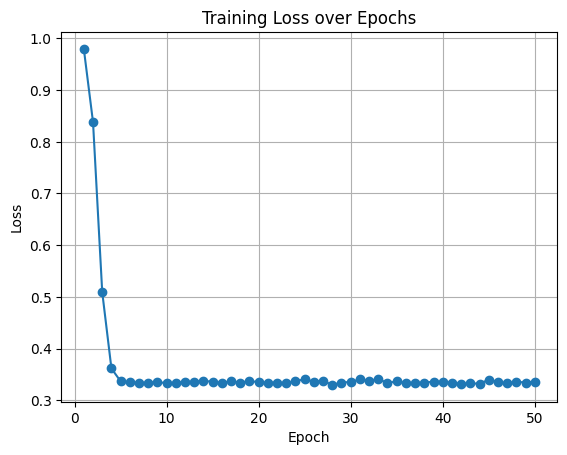

In [6]:
import matplotlib.pyplot as plt
epoch_losses = []

class RMSRELoss(nn.Module):
    def __init__(self):
        super(RMSRELoss, self).__init__()

    def forward(self, y_pred, y_true):
        epsilon = 1e-6  # Small value to avoid division by zero
        relative_error = (y_pred - y_true) / (y_true + epsilon)
        return torch.sqrt(torch.mean(relative_error ** 2))
    
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

model = CombinedModel()
criterion = RMSRELoss()  
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Reduced learning rate

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
device = torch.device("cuda")

model = model.to(device)
criterion = criterion.to(device)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        sequential_data = batch['sequential_data'].to(device)
        img_b = batch['img_b'].to(device)
        img_l = batch['img_l'].to(device)
        numeric_data = batch['numeric_data'].to(device)
        viome_sequential = batch['viome_sequential'].to(device)
        label = batch['label'].to(device)
        
        # Forward pass
        outputs = model(sequential_data, img_b, img_l, numeric_data, viome_sequential)
        loss = criterion(outputs, label)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}")

    scheduler.step()

print("Training complete.")

plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()


In [7]:

model.eval()  # Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
test_loss = 0.0
all_outputs = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation
    for batch in test_loader:
        sequential_data = batch['sequential_data'].to(device)
        img_b = batch['img_b'].to(device)
        img_l = batch['img_l'].to(device)
        numeric_data = batch['numeric_data'].to(device)
        viome_sequential = batch['viome_sequential'].to(device)
        
        # Forward pass
        outputs = model(sequential_data, img_b, img_l, numeric_data, viome_sequential)
        
        all_outputs += ([i[0] for i in outputs.tolist()])
        
test_ids = np.arange(len(all_outputs))  
submission = pd.DataFrame({"row_id": test_ids, "label": all_outputs})
submission.to_csv("submission.csv", index=False)
print("Predictions saved to 'submission.csv' in Kaggle format.")


Predictions saved to 'submission.csv' in Kaggle format.


In [39]:
# Hyperparameters
hidden_sizes = [32, 64, 128]
learning_rates = [1e-3, 1e-4]
batch_sizes = [16, 32, 64]

best_loss = float('inf')
best_model = None

# Iterate over different combinations of hyperparameters to find the best model
for hidden_size in hidden_sizes:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            # Create the dataset loader for training and testing
            train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
            
            model = CombinedModel(hidden_size=hidden_size)
            criterion = RMSRELoss()  
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            # Learning rate scheduler
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
            
            # Set up the device
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model = model.to(device)
            criterion = criterion.to(device)
            
            # Training process
            num_epochs = 50
            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                for batch in train_loader:
                    # Move data to device
                    sequential_data = batch['sequential_data'].to(device)
                    img_b = batch['img_b'].to(device)
                    img_l = batch['img_l'].to(device)
                    numeric_data = batch['numeric_data'].to(device)
                    viome_sequential = batch['viome_sequential'].to(device)
                    label = batch['label'].to(device)
                    
                    # Forward pass
                    outputs = model(sequential_data, img_b, img_l, numeric_data, viome_sequential)
                    loss = criterion(outputs, label)
                    
                    # Backward pass and optimization
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    running_loss += loss.item()
                scheduler.step()
                
                avg_loss = running_loss / len(train_loader)
                print(f"Epoch [{epoch+1}/{num_epochs}], Hidden Size: {hidden_size}, LR: {lr}, Batch Size: {batch_size}, Loss: {avg_loss:.4f}")
            
            # Save the best model
            if avg_loss < best_loss:
                best_loss = avg_loss
                best_model = model

# Use the best trained model for predictions
best_model.eval()  # Set the model to evaluation mode



c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Hidden Size: 32, LR: 0.001, Batch Size: 16, Loss: 0.9222
Epoch [2/50], Hidden Size: 32, LR: 0.001, Batch Size: 16, Loss: 0.4521
Epoch [3/50], Hidden Size: 32, LR: 0.001, Batch Size: 16, Loss: 0.3379
Epoch [4/50], Hidden Size: 32, LR: 0.001, Batch Size: 16, Loss: 0.3320
Epoch [5/50], Hidden Size: 32, LR: 0.001, Batch Size: 16, Loss: 0.3355
Epoch [6/50], Hidden Size: 32, LR: 0.001, Batch Size: 16, Loss: 0.3353
Epoch [7/50], Hidden Size: 32, LR: 0.001, Batch Size: 16, Loss: 0.3343
Epoch [8/50], Hidden Size: 32, LR: 0.001, Batch Size: 16, Loss: 0.3314
Epoch [9/50], Hidden Size: 32, LR: 0.001, Batch Size: 16, Loss: 0.3312
Epoch [10/50], Hidden Size: 32, LR: 0.001, Batch Size: 16, Loss: 0.3356
Epoch [11/50], Hidden Size: 32, LR: 0.001, Batch Size: 16, Loss: 0.3353
Epoch [12/50], Hidden Size: 32, LR: 0.001, Batch Size: 16, Loss: 0.3386
Epoch [13/50], Hidden Size: 32, LR: 0.001, Batch Size: 16, Loss: 0.3473
Epoch [14/50], Hidden Size: 32, LR: 0.001, Batch Size: 16, Loss: 0.3319
E

c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Hidden Size: 32, LR: 0.001, Batch Size: 32, Loss: 0.9606
Epoch [2/50], Hidden Size: 32, LR: 0.001, Batch Size: 32, Loss: 0.7038
Epoch [3/50], Hidden Size: 32, LR: 0.001, Batch Size: 32, Loss: 0.3803
Epoch [4/50], Hidden Size: 32, LR: 0.001, Batch Size: 32, Loss: 0.3452
Epoch [5/50], Hidden Size: 32, LR: 0.001, Batch Size: 32, Loss: 0.3354
Epoch [6/50], Hidden Size: 32, LR: 0.001, Batch Size: 32, Loss: 0.3336
Epoch [7/50], Hidden Size: 32, LR: 0.001, Batch Size: 32, Loss: 0.3340
Epoch [8/50], Hidden Size: 32, LR: 0.001, Batch Size: 32, Loss: 0.3333
Epoch [9/50], Hidden Size: 32, LR: 0.001, Batch Size: 32, Loss: 0.3387
Epoch [10/50], Hidden Size: 32, LR: 0.001, Batch Size: 32, Loss: 0.3349
Epoch [11/50], Hidden Size: 32, LR: 0.001, Batch Size: 32, Loss: 0.3347
Epoch [12/50], Hidden Size: 32, LR: 0.001, Batch Size: 32, Loss: 0.3358
Epoch [13/50], Hidden Size: 32, LR: 0.001, Batch Size: 32, Loss: 0.3355
Epoch [14/50], Hidden Size: 32, LR: 0.001, Batch Size: 32, Loss: 0.3344
E

c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Hidden Size: 32, LR: 0.001, Batch Size: 64, Loss: 0.9941
Epoch [2/50], Hidden Size: 32, LR: 0.001, Batch Size: 64, Loss: 0.9525
Epoch [3/50], Hidden Size: 32, LR: 0.001, Batch Size: 64, Loss: 0.8561
Epoch [4/50], Hidden Size: 32, LR: 0.001, Batch Size: 64, Loss: 0.6962
Epoch [5/50], Hidden Size: 32, LR: 0.001, Batch Size: 64, Loss: 0.4681
Epoch [6/50], Hidden Size: 32, LR: 0.001, Batch Size: 64, Loss: 0.3543
Epoch [7/50], Hidden Size: 32, LR: 0.001, Batch Size: 64, Loss: 0.3626
Epoch [8/50], Hidden Size: 32, LR: 0.001, Batch Size: 64, Loss: 0.3457
Epoch [9/50], Hidden Size: 32, LR: 0.001, Batch Size: 64, Loss: 0.3332
Epoch [10/50], Hidden Size: 32, LR: 0.001, Batch Size: 64, Loss: 0.3326
Epoch [11/50], Hidden Size: 32, LR: 0.001, Batch Size: 64, Loss: 0.3329
Epoch [12/50], Hidden Size: 32, LR: 0.001, Batch Size: 64, Loss: 0.3283
Epoch [13/50], Hidden Size: 32, LR: 0.001, Batch Size: 64, Loss: 0.3295
Epoch [14/50], Hidden Size: 32, LR: 0.001, Batch Size: 64, Loss: 0.3376
E

c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Hidden Size: 32, LR: 0.0001, Batch Size: 16, Loss: 0.9978
Epoch [2/50], Hidden Size: 32, LR: 0.0001, Batch Size: 16, Loss: 0.9885
Epoch [3/50], Hidden Size: 32, LR: 0.0001, Batch Size: 16, Loss: 0.9674
Epoch [4/50], Hidden Size: 32, LR: 0.0001, Batch Size: 16, Loss: 0.9276
Epoch [5/50], Hidden Size: 32, LR: 0.0001, Batch Size: 16, Loss: 0.8711
Epoch [6/50], Hidden Size: 32, LR: 0.0001, Batch Size: 16, Loss: 0.7948
Epoch [7/50], Hidden Size: 32, LR: 0.0001, Batch Size: 16, Loss: 0.7010
Epoch [8/50], Hidden Size: 32, LR: 0.0001, Batch Size: 16, Loss: 0.5892
Epoch [9/50], Hidden Size: 32, LR: 0.0001, Batch Size: 16, Loss: 0.4734
Epoch [10/50], Hidden Size: 32, LR: 0.0001, Batch Size: 16, Loss: 0.3713
Epoch [11/50], Hidden Size: 32, LR: 0.0001, Batch Size: 16, Loss: 0.3352
Epoch [12/50], Hidden Size: 32, LR: 0.0001, Batch Size: 16, Loss: 0.3304
Epoch [13/50], Hidden Size: 32, LR: 0.0001, Batch Size: 16, Loss: 0.3317
Epoch [14/50], Hidden Size: 32, LR: 0.0001, Batch Size: 16, 

c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Hidden Size: 32, LR: 0.0001, Batch Size: 32, Loss: 0.9989
Epoch [2/50], Hidden Size: 32, LR: 0.0001, Batch Size: 32, Loss: 0.9959
Epoch [3/50], Hidden Size: 32, LR: 0.0001, Batch Size: 32, Loss: 0.9910
Epoch [4/50], Hidden Size: 32, LR: 0.0001, Batch Size: 32, Loss: 0.9829
Epoch [5/50], Hidden Size: 32, LR: 0.0001, Batch Size: 32, Loss: 0.9698
Epoch [6/50], Hidden Size: 32, LR: 0.0001, Batch Size: 32, Loss: 0.9510
Epoch [7/50], Hidden Size: 32, LR: 0.0001, Batch Size: 32, Loss: 0.9269
Epoch [8/50], Hidden Size: 32, LR: 0.0001, Batch Size: 32, Loss: 0.8982
Epoch [9/50], Hidden Size: 32, LR: 0.0001, Batch Size: 32, Loss: 0.8629
Epoch [10/50], Hidden Size: 32, LR: 0.0001, Batch Size: 32, Loss: 0.8230
Epoch [11/50], Hidden Size: 32, LR: 0.0001, Batch Size: 32, Loss: 0.7770
Epoch [12/50], Hidden Size: 32, LR: 0.0001, Batch Size: 32, Loss: 0.7239
Epoch [13/50], Hidden Size: 32, LR: 0.0001, Batch Size: 32, Loss: 0.6633
Epoch [14/50], Hidden Size: 32, LR: 0.0001, Batch Size: 32, 

c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Hidden Size: 32, LR: 0.0001, Batch Size: 64, Loss: 0.9996
Epoch [2/50], Hidden Size: 32, LR: 0.0001, Batch Size: 64, Loss: 0.9984
Epoch [3/50], Hidden Size: 32, LR: 0.0001, Batch Size: 64, Loss: 0.9967
Epoch [4/50], Hidden Size: 32, LR: 0.0001, Batch Size: 64, Loss: 0.9947
Epoch [5/50], Hidden Size: 32, LR: 0.0001, Batch Size: 64, Loss: 0.9922
Epoch [6/50], Hidden Size: 32, LR: 0.0001, Batch Size: 64, Loss: 0.9883
Epoch [7/50], Hidden Size: 32, LR: 0.0001, Batch Size: 64, Loss: 0.9835
Epoch [8/50], Hidden Size: 32, LR: 0.0001, Batch Size: 64, Loss: 0.9775
Epoch [9/50], Hidden Size: 32, LR: 0.0001, Batch Size: 64, Loss: 0.9700
Epoch [10/50], Hidden Size: 32, LR: 0.0001, Batch Size: 64, Loss: 0.9622
Epoch [11/50], Hidden Size: 32, LR: 0.0001, Batch Size: 64, Loss: 0.9522
Epoch [12/50], Hidden Size: 32, LR: 0.0001, Batch Size: 64, Loss: 0.9425
Epoch [13/50], Hidden Size: 32, LR: 0.0001, Batch Size: 64, Loss: 0.9293
Epoch [14/50], Hidden Size: 32, LR: 0.0001, Batch Size: 64, 

c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Hidden Size: 64, LR: 0.001, Batch Size: 16, Loss: 0.9390
Epoch [2/50], Hidden Size: 64, LR: 0.001, Batch Size: 16, Loss: 0.4934
Epoch [3/50], Hidden Size: 64, LR: 0.001, Batch Size: 16, Loss: 0.3472
Epoch [4/50], Hidden Size: 64, LR: 0.001, Batch Size: 16, Loss: 0.3361
Epoch [5/50], Hidden Size: 64, LR: 0.001, Batch Size: 16, Loss: 0.3359
Epoch [6/50], Hidden Size: 64, LR: 0.001, Batch Size: 16, Loss: 0.3303
Epoch [7/50], Hidden Size: 64, LR: 0.001, Batch Size: 16, Loss: 0.3345
Epoch [8/50], Hidden Size: 64, LR: 0.001, Batch Size: 16, Loss: 0.3361
Epoch [9/50], Hidden Size: 64, LR: 0.001, Batch Size: 16, Loss: 0.3379
Epoch [10/50], Hidden Size: 64, LR: 0.001, Batch Size: 16, Loss: 0.3355
Epoch [11/50], Hidden Size: 64, LR: 0.001, Batch Size: 16, Loss: 0.3352
Epoch [12/50], Hidden Size: 64, LR: 0.001, Batch Size: 16, Loss: 0.3319
Epoch [13/50], Hidden Size: 64, LR: 0.001, Batch Size: 16, Loss: 0.3336
Epoch [14/50], Hidden Size: 64, LR: 0.001, Batch Size: 16, Loss: 0.3379
E

c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Hidden Size: 64, LR: 0.001, Batch Size: 32, Loss: 0.9739
Epoch [2/50], Hidden Size: 64, LR: 0.001, Batch Size: 32, Loss: 0.7999
Epoch [3/50], Hidden Size: 64, LR: 0.001, Batch Size: 32, Loss: 0.4388
Epoch [4/50], Hidden Size: 64, LR: 0.001, Batch Size: 32, Loss: 0.3716
Epoch [5/50], Hidden Size: 64, LR: 0.001, Batch Size: 32, Loss: 0.3346
Epoch [6/50], Hidden Size: 64, LR: 0.001, Batch Size: 32, Loss: 0.3337
Epoch [7/50], Hidden Size: 64, LR: 0.001, Batch Size: 32, Loss: 0.3337
Epoch [8/50], Hidden Size: 64, LR: 0.001, Batch Size: 32, Loss: 0.3351
Epoch [9/50], Hidden Size: 64, LR: 0.001, Batch Size: 32, Loss: 0.3353
Epoch [10/50], Hidden Size: 64, LR: 0.001, Batch Size: 32, Loss: 0.3346
Epoch [11/50], Hidden Size: 64, LR: 0.001, Batch Size: 32, Loss: 0.3348
Epoch [12/50], Hidden Size: 64, LR: 0.001, Batch Size: 32, Loss: 0.3329
Epoch [13/50], Hidden Size: 64, LR: 0.001, Batch Size: 32, Loss: 0.3343
Epoch [14/50], Hidden Size: 64, LR: 0.001, Batch Size: 32, Loss: 0.3342
E

c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Hidden Size: 64, LR: 0.001, Batch Size: 64, Loss: 0.9931
Epoch [2/50], Hidden Size: 64, LR: 0.001, Batch Size: 64, Loss: 0.9493
Epoch [3/50], Hidden Size: 64, LR: 0.001, Batch Size: 64, Loss: 0.8533
Epoch [4/50], Hidden Size: 64, LR: 0.001, Batch Size: 64, Loss: 0.6944
Epoch [5/50], Hidden Size: 64, LR: 0.001, Batch Size: 64, Loss: 0.4712
Epoch [6/50], Hidden Size: 64, LR: 0.001, Batch Size: 64, Loss: 0.3578
Epoch [7/50], Hidden Size: 64, LR: 0.001, Batch Size: 64, Loss: 0.3724
Epoch [8/50], Hidden Size: 64, LR: 0.001, Batch Size: 64, Loss: 0.3385
Epoch [9/50], Hidden Size: 64, LR: 0.001, Batch Size: 64, Loss: 0.3372
Epoch [10/50], Hidden Size: 64, LR: 0.001, Batch Size: 64, Loss: 0.3371
Epoch [11/50], Hidden Size: 64, LR: 0.001, Batch Size: 64, Loss: 0.3374
Epoch [12/50], Hidden Size: 64, LR: 0.001, Batch Size: 64, Loss: 0.3393
Epoch [13/50], Hidden Size: 64, LR: 0.001, Batch Size: 64, Loss: 0.3280
Epoch [14/50], Hidden Size: 64, LR: 0.001, Batch Size: 64, Loss: 0.3341
E

c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Hidden Size: 64, LR: 0.0001, Batch Size: 16, Loss: 0.9978
Epoch [2/50], Hidden Size: 64, LR: 0.0001, Batch Size: 16, Loss: 0.9896
Epoch [3/50], Hidden Size: 64, LR: 0.0001, Batch Size: 16, Loss: 0.9681
Epoch [4/50], Hidden Size: 64, LR: 0.0001, Batch Size: 16, Loss: 0.9271
Epoch [5/50], Hidden Size: 64, LR: 0.0001, Batch Size: 16, Loss: 0.8665
Epoch [6/50], Hidden Size: 64, LR: 0.0001, Batch Size: 16, Loss: 0.7866
Epoch [7/50], Hidden Size: 64, LR: 0.0001, Batch Size: 16, Loss: 0.6877
Epoch [8/50], Hidden Size: 64, LR: 0.0001, Batch Size: 16, Loss: 0.5682
Epoch [9/50], Hidden Size: 64, LR: 0.0001, Batch Size: 16, Loss: 0.4423
Epoch [10/50], Hidden Size: 64, LR: 0.0001, Batch Size: 16, Loss: 0.3537
Epoch [11/50], Hidden Size: 64, LR: 0.0001, Batch Size: 16, Loss: 0.3327
Epoch [12/50], Hidden Size: 64, LR: 0.0001, Batch Size: 16, Loss: 0.3298
Epoch [13/50], Hidden Size: 64, LR: 0.0001, Batch Size: 16, Loss: 0.3310
Epoch [14/50], Hidden Size: 64, LR: 0.0001, Batch Size: 16, 

c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Hidden Size: 64, LR: 0.0001, Batch Size: 32, Loss: 0.9992
Epoch [2/50], Hidden Size: 64, LR: 0.0001, Batch Size: 32, Loss: 0.9967
Epoch [3/50], Hidden Size: 64, LR: 0.0001, Batch Size: 32, Loss: 0.9928
Epoch [4/50], Hidden Size: 64, LR: 0.0001, Batch Size: 32, Loss: 0.9862
Epoch [5/50], Hidden Size: 64, LR: 0.0001, Batch Size: 32, Loss: 0.9756
Epoch [6/50], Hidden Size: 64, LR: 0.0001, Batch Size: 32, Loss: 0.9605
Epoch [7/50], Hidden Size: 64, LR: 0.0001, Batch Size: 32, Loss: 0.9402
Epoch [8/50], Hidden Size: 64, LR: 0.0001, Batch Size: 32, Loss: 0.9162
Epoch [9/50], Hidden Size: 64, LR: 0.0001, Batch Size: 32, Loss: 0.8876
Epoch [10/50], Hidden Size: 64, LR: 0.0001, Batch Size: 32, Loss: 0.8526
Epoch [11/50], Hidden Size: 64, LR: 0.0001, Batch Size: 32, Loss: 0.8131
Epoch [12/50], Hidden Size: 64, LR: 0.0001, Batch Size: 32, Loss: 0.7685
Epoch [13/50], Hidden Size: 64, LR: 0.0001, Batch Size: 32, Loss: 0.7175
Epoch [14/50], Hidden Size: 64, LR: 0.0001, Batch Size: 32, 

c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Hidden Size: 64, LR: 0.0001, Batch Size: 64, Loss: 0.9996
Epoch [2/50], Hidden Size: 64, LR: 0.0001, Batch Size: 64, Loss: 0.9980
Epoch [3/50], Hidden Size: 64, LR: 0.0001, Batch Size: 64, Loss: 0.9958
Epoch [4/50], Hidden Size: 64, LR: 0.0001, Batch Size: 64, Loss: 0.9932
Epoch [5/50], Hidden Size: 64, LR: 0.0001, Batch Size: 64, Loss: 0.9898
Epoch [6/50], Hidden Size: 64, LR: 0.0001, Batch Size: 64, Loss: 0.9851
Epoch [7/50], Hidden Size: 64, LR: 0.0001, Batch Size: 64, Loss: 0.9785
Epoch [8/50], Hidden Size: 64, LR: 0.0001, Batch Size: 64, Loss: 0.9711
Epoch [9/50], Hidden Size: 64, LR: 0.0001, Batch Size: 64, Loss: 0.9623
Epoch [10/50], Hidden Size: 64, LR: 0.0001, Batch Size: 64, Loss: 0.9512
Epoch [11/50], Hidden Size: 64, LR: 0.0001, Batch Size: 64, Loss: 0.9400
Epoch [12/50], Hidden Size: 64, LR: 0.0001, Batch Size: 64, Loss: 0.9280
Epoch [13/50], Hidden Size: 64, LR: 0.0001, Batch Size: 64, Loss: 0.9106
Epoch [14/50], Hidden Size: 64, LR: 0.0001, Batch Size: 64, 

c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Hidden Size: 128, LR: 0.001, Batch Size: 16, Loss: 0.9020
Epoch [2/50], Hidden Size: 128, LR: 0.001, Batch Size: 16, Loss: 0.4277
Epoch [3/50], Hidden Size: 128, LR: 0.001, Batch Size: 16, Loss: 0.3361
Epoch [4/50], Hidden Size: 128, LR: 0.001, Batch Size: 16, Loss: 0.3342
Epoch [5/50], Hidden Size: 128, LR: 0.001, Batch Size: 16, Loss: 0.3357
Epoch [6/50], Hidden Size: 128, LR: 0.001, Batch Size: 16, Loss: 0.3313
Epoch [7/50], Hidden Size: 128, LR: 0.001, Batch Size: 16, Loss: 0.3368
Epoch [8/50], Hidden Size: 128, LR: 0.001, Batch Size: 16, Loss: 0.3339
Epoch [9/50], Hidden Size: 128, LR: 0.001, Batch Size: 16, Loss: 0.3381
Epoch [10/50], Hidden Size: 128, LR: 0.001, Batch Size: 16, Loss: 0.3337
Epoch [11/50], Hidden Size: 128, LR: 0.001, Batch Size: 16, Loss: 0.3332
Epoch [12/50], Hidden Size: 128, LR: 0.001, Batch Size: 16, Loss: 0.3312
Epoch [13/50], Hidden Size: 128, LR: 0.001, Batch Size: 16, Loss: 0.3345
Epoch [14/50], Hidden Size: 128, LR: 0.001, Batch Size: 16, 

c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Hidden Size: 128, LR: 0.001, Batch Size: 32, Loss: 0.9773
Epoch [2/50], Hidden Size: 128, LR: 0.001, Batch Size: 32, Loss: 0.8262
Epoch [3/50], Hidden Size: 128, LR: 0.001, Batch Size: 32, Loss: 0.4931
Epoch [4/50], Hidden Size: 128, LR: 0.001, Batch Size: 32, Loss: 0.3642
Epoch [5/50], Hidden Size: 128, LR: 0.001, Batch Size: 32, Loss: 0.3356
Epoch [6/50], Hidden Size: 128, LR: 0.001, Batch Size: 32, Loss: 0.3353
Epoch [7/50], Hidden Size: 128, LR: 0.001, Batch Size: 32, Loss: 0.3344
Epoch [8/50], Hidden Size: 128, LR: 0.001, Batch Size: 32, Loss: 0.3327
Epoch [9/50], Hidden Size: 128, LR: 0.001, Batch Size: 32, Loss: 0.3354
Epoch [10/50], Hidden Size: 128, LR: 0.001, Batch Size: 32, Loss: 0.3326
Epoch [11/50], Hidden Size: 128, LR: 0.001, Batch Size: 32, Loss: 0.3349
Epoch [12/50], Hidden Size: 128, LR: 0.001, Batch Size: 32, Loss: 0.3347
Epoch [13/50], Hidden Size: 128, LR: 0.001, Batch Size: 32, Loss: 0.3363
Epoch [14/50], Hidden Size: 128, LR: 0.001, Batch Size: 32, 

c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Hidden Size: 128, LR: 0.001, Batch Size: 64, Loss: 0.9936
Epoch [2/50], Hidden Size: 128, LR: 0.001, Batch Size: 64, Loss: 0.9478
Epoch [3/50], Hidden Size: 128, LR: 0.001, Batch Size: 64, Loss: 0.8378
Epoch [4/50], Hidden Size: 128, LR: 0.001, Batch Size: 64, Loss: 0.6622
Epoch [5/50], Hidden Size: 128, LR: 0.001, Batch Size: 64, Loss: 0.4256
Epoch [6/50], Hidden Size: 128, LR: 0.001, Batch Size: 64, Loss: 0.3641
Epoch [7/50], Hidden Size: 128, LR: 0.001, Batch Size: 64, Loss: 0.3702
Epoch [8/50], Hidden Size: 128, LR: 0.001, Batch Size: 64, Loss: 0.3351
Epoch [9/50], Hidden Size: 128, LR: 0.001, Batch Size: 64, Loss: 0.3292
Epoch [10/50], Hidden Size: 128, LR: 0.001, Batch Size: 64, Loss: 0.3294
Epoch [11/50], Hidden Size: 128, LR: 0.001, Batch Size: 64, Loss: 0.3384
Epoch [12/50], Hidden Size: 128, LR: 0.001, Batch Size: 64, Loss: 0.3389
Epoch [13/50], Hidden Size: 128, LR: 0.001, Batch Size: 64, Loss: 0.3397
Epoch [14/50], Hidden Size: 128, LR: 0.001, Batch Size: 64, 

c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Hidden Size: 128, LR: 0.0001, Batch Size: 16, Loss: 0.9967
Epoch [2/50], Hidden Size: 128, LR: 0.0001, Batch Size: 16, Loss: 0.9855
Epoch [3/50], Hidden Size: 128, LR: 0.0001, Batch Size: 16, Loss: 0.9581
Epoch [4/50], Hidden Size: 128, LR: 0.0001, Batch Size: 16, Loss: 0.9084
Epoch [5/50], Hidden Size: 128, LR: 0.0001, Batch Size: 16, Loss: 0.8368
Epoch [6/50], Hidden Size: 128, LR: 0.0001, Batch Size: 16, Loss: 0.7393
Epoch [7/50], Hidden Size: 128, LR: 0.0001, Batch Size: 16, Loss: 0.6215
Epoch [8/50], Hidden Size: 128, LR: 0.0001, Batch Size: 16, Loss: 0.4811
Epoch [9/50], Hidden Size: 128, LR: 0.0001, Batch Size: 16, Loss: 0.3732
Epoch [10/50], Hidden Size: 128, LR: 0.0001, Batch Size: 16, Loss: 0.3346
Epoch [11/50], Hidden Size: 128, LR: 0.0001, Batch Size: 16, Loss: 0.3321
Epoch [12/50], Hidden Size: 128, LR: 0.0001, Batch Size: 16, Loss: 0.3325
Epoch [13/50], Hidden Size: 128, LR: 0.0001, Batch Size: 16, Loss: 0.3355
Epoch [14/50], Hidden Size: 128, LR: 0.0001, Ba

c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Hidden Size: 128, LR: 0.0001, Batch Size: 32, Loss: 0.9994
Epoch [2/50], Hidden Size: 128, LR: 0.0001, Batch Size: 32, Loss: 0.9966
Epoch [3/50], Hidden Size: 128, LR: 0.0001, Batch Size: 32, Loss: 0.9920
Epoch [4/50], Hidden Size: 128, LR: 0.0001, Batch Size: 32, Loss: 0.9844
Epoch [5/50], Hidden Size: 128, LR: 0.0001, Batch Size: 32, Loss: 0.9722
Epoch [6/50], Hidden Size: 128, LR: 0.0001, Batch Size: 32, Loss: 0.9551
Epoch [7/50], Hidden Size: 128, LR: 0.0001, Batch Size: 32, Loss: 0.9335
Epoch [8/50], Hidden Size: 128, LR: 0.0001, Batch Size: 32, Loss: 0.9076
Epoch [9/50], Hidden Size: 128, LR: 0.0001, Batch Size: 32, Loss: 0.8772
Epoch [10/50], Hidden Size: 128, LR: 0.0001, Batch Size: 32, Loss: 0.8430
Epoch [11/50], Hidden Size: 128, LR: 0.0001, Batch Size: 32, Loss: 0.8021
Epoch [12/50], Hidden Size: 128, LR: 0.0001, Batch Size: 32, Loss: 0.7550
Epoch [13/50], Hidden Size: 128, LR: 0.0001, Batch Size: 32, Loss: 0.7032
Epoch [14/50], Hidden Size: 128, LR: 0.0001, Ba

c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\10374\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Hidden Size: 128, LR: 0.0001, Batch Size: 64, Loss: 0.9995
Epoch [2/50], Hidden Size: 128, LR: 0.0001, Batch Size: 64, Loss: 0.9979
Epoch [3/50], Hidden Size: 128, LR: 0.0001, Batch Size: 64, Loss: 0.9958
Epoch [4/50], Hidden Size: 128, LR: 0.0001, Batch Size: 64, Loss: 0.9931
Epoch [5/50], Hidden Size: 128, LR: 0.0001, Batch Size: 64, Loss: 0.9893
Epoch [6/50], Hidden Size: 128, LR: 0.0001, Batch Size: 64, Loss: 0.9847
Epoch [7/50], Hidden Size: 128, LR: 0.0001, Batch Size: 64, Loss: 0.9785
Epoch [8/50], Hidden Size: 128, LR: 0.0001, Batch Size: 64, Loss: 0.9706
Epoch [9/50], Hidden Size: 128, LR: 0.0001, Batch Size: 64, Loss: 0.9618
Epoch [10/50], Hidden Size: 128, LR: 0.0001, Batch Size: 64, Loss: 0.9516
Epoch [11/50], Hidden Size: 128, LR: 0.0001, Batch Size: 64, Loss: 0.9396
Epoch [12/50], Hidden Size: 128, LR: 0.0001, Batch Size: 64, Loss: 0.9255
Epoch [13/50], Hidden Size: 128, LR: 0.0001, Batch Size: 64, Loss: 0.9108
Epoch [14/50], Hidden Size: 128, LR: 0.0001, Ba

CombinedModel(
  (seq_net): LSTM(2, 64, batch_first=True)
  (seq_fc): Linear(in_features=64, out_features=32, bias=True)
  (viome_net): LSTM(1, 64, batch_first=True)
  (viome_fc): Linear(in_features=64, out_features=32, bias=True)
  (img_net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, 

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Use the best trained model for predictions
best_model.eval()  # Set the model to evaluation mode
test_loss = 0.0
all_outputs = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation
    for batch in test_loader:
        sequential_data = batch['sequential_data'].to(device)
        img_b = batch['img_b'].to(device)
        img_l = batch['img_l'].to(device)
        numeric_data = batch['numeric_data'].to(device)
        viome_sequential = batch['viome_sequential'].to(device)
        
        # Forward pass
        outputs = model(sequential_data, img_b, img_l, numeric_data, viome_sequential)
        
        all_outputs += ([i[0] for i in outputs.tolist()])
        
test_ids = np.arange(len(all_outputs)) 
submission = pd.DataFrame({"row_id": test_ids, "label": all_outputs})
submission.to_csv("submission.csv", index=False)
print("Predictions saved to 'submission.csv' in Kaggle format.")


Predictions saved to 'submission.csv' in Kaggle format.
